# SORN CODE

**TODO_IMPLEMENT**
* Ensure principal axis of all matrices and operations are correct [python is row-major like C++]
* Copy estimators
* Test-run
* Extend to ELMAN task

**TODO-IMPROVE**
* Fix synaptic plasticity not to require normalization (understand its purpose in the first place)
* Fix synaptic plasticity not to require truncation    (use edge functions)
* Switch to sparse matrices for scalability

**TODO-MODEL**
* How input and output work in SORN?
  * Is input orthogonal-coded or binary?
  * Is binary realistic for brain?
  * Can SORN handle binary?
  * How to make output match input?
* How should we choose neurons that exhibit intrinsic plasticity? All excitatory?
* Implement noisy global synchronization a la astrocyte



In [6]:
# Do all important inputs
from time import time
import brian2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload

matplotlib.rcParams.update({'font.size': 14})

# Import SORN libraries
import aux
from seqgen import seqGen
from reservoirmemory import ReservoirMemory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# DEBUG: Allows reload of import modules if they were changed
%autoreload 2

########################
## declare parameters
########################

# Simulation parameters
N_NEURON = 200;
N_NEURON_EXC = int(0.8 * N_NEURON);
N_NEURON_INH = int(0.2 * N_NEURON);
TIME_TOT = 5000; #ms

# Input
INP_N_NEURON = 60;
INP_WORD_LENGTHS = [3, 3]
INP_WORD_FREQ = [0.1, 0.1]

# Model parameters
param = {
    'N_EXC' : N_NEURON_EXC,  #number of excitatory neurons
    'N_INH' : N_NEURON_INH,  #number of inhibitory neurons
    
    'P_CONN_EE' : 0.05,  # fraction of excitatory->excitatory connections out of all possible
    'P_CONN_IE' : 1.0,   # fraction of inhibitory->excitatory connections out of all possible
    'P_CONN_EI' : 0.2,   # fraction of excitatory->inhibitory connections out of all possible
    'P_CONN_II' : 1.0,   # fraction of inhibitory->inhibitory connections out of all possible
    
    'W_RANGE_EXC' : [0.0, 0.5],   # Range of excitatory weights
    'W_RANGE_INH' : [-0.5, 0.0],  # Range of inhibitory weights
    'W_NORM_EXC' : 1.0,  # ???
    'W_NORM_INH' : 0.5,  # ???
    
    'IP_ACTIVE_NEURON_RANGE' : range(INP_N_NEURON, N_NEURON_EXC),  # Only extitatory neurons without input have synaptic plasticity
    'THR_RANGE_EXC' : [0.0, 0.75],  # Excitatory neuron thresholds random within this range
    'THR_RANGE_INH' : [0.0, 0.2],   # Inhibitory neuron thresholds random within this range
    
    'EQ_RATE_IP_EXC' : 0.1,  # Equillibrium spiking rate for excitatory intrinsic plasticity
    'EQ_RATE_IP_INH' : 0.3,  # Equillibrium spiking rate for inhibitory intrinsic plasticity
    
    'IP_RATE' :  0.001, #Rate of threshold change due to intrinsic plasticity
    'SP_RATE' :  0.001  #Rate of weight change due to synaptic plasticity
}

########################
## Generate Input Sequence
########################
INP_SEQ = seqGen(N_NEURON, INP_N_NEURON, INP_WORD_LENGTHS, INP_WORD_FREQ, TIME_TOT)

# Plot the first 1000 timesteps of the input to have an idea of how it looks like
my_dpi=100
my_fps=300
# aux.saveMatPlot(INP_SEQ, 'rez/sorn_input.png', my_dpi)

# tbegin = time()
# aux.longMatMovie(INP_SEQ, 1000, 'rez/sorn_input', my_dpi, my_fps)
# print("Written iput movie in ", time() - tbegin)

#############################
## Initialize and run model
#############################

RM1 = ReservoirMemory(param)
T_REST = 1000
T_IP   = 1000 + T_REST

# aux.saveMatPlot(RM1.WRR, 'rez/sorn_wmatrix.png', my_dpi)

tbegin = time()
RM1.evolve(INP_SEQ[:T_REST],      allowIP=False, allowSP=False)
print("Stabilization segment done in", time() - tbegin)

# tbegin = time()
# aux.longMatMovie(INP_SEQ, 1000, 'rez/sorn_input', my_dpi, my_fps)
# print("Written iput movie in ", time() - tbegin)

tbegin = time()
RM1.evolve(INP_SEQ[T_REST:T_IP], allowIP=True, allowSP=False)
print("IP segment done in", time() - tbegin)

tbegin = time()
RM1.evolve(INP_SEQ[T_IP:],      allowIP=True, allowSP=True)
print("IP-SP segment done in", time() - tbegin)

aux.saveMatPlot(INP_SEQ[:T_REST], 'rez/sorn_input.png', my_dpi)
aux.saveMatPlot(INP_SEQ[T_REST:T_IP], 'rez/sorn_input_IP.png', my_dpi)
aux.saveMatPlot(INP_SEQ[T_IP:], 'rez/sorn_input_SP.png', my_dpi)
aux.saveMatPlot(np.array(RM1.V_Lst)[:T_REST], 'rez/sorn_rez_state.png', 10)
aux.saveMatPlot(np.array(RM1.V_Lst)[T_REST:T_IP], 'rez/sorn_rez_state_IP.png', 10)
aux.saveMatPlot(np.array(RM1.V_Lst)[T_IP:], 'rez/sorn_rez_state_SP.png', 10)

##################################################
## Use Bayes black magic to compare output to
##################################################

#     %% output vector
#     % out = input1&input2

#     aux  = max(sum(U(1:NU/2,:))>0,(sum(U(NU/2+1:NU,:))>0)*2);
    
    
#     #input shift => memory or prediction
#     lagVect = -10:1:10;  
            
#     output = zeros(length(lagVect),Time);
#     for j = 1:length(lagVect) %j is the delay used to look into the past

#           output(j,(max(lagVect)+1:(Time-max(lagVect))))= aux((max(lagVect)+1:(Time-max(lagVect)))+lagVect(j));
       
#     end
    

Stabilization segment done in 0.02482295036315918
IP segment done in 0.02608323097229004
IP-SP segment done in 1.7518765926361084


<IPython.core.display.Javascript object>


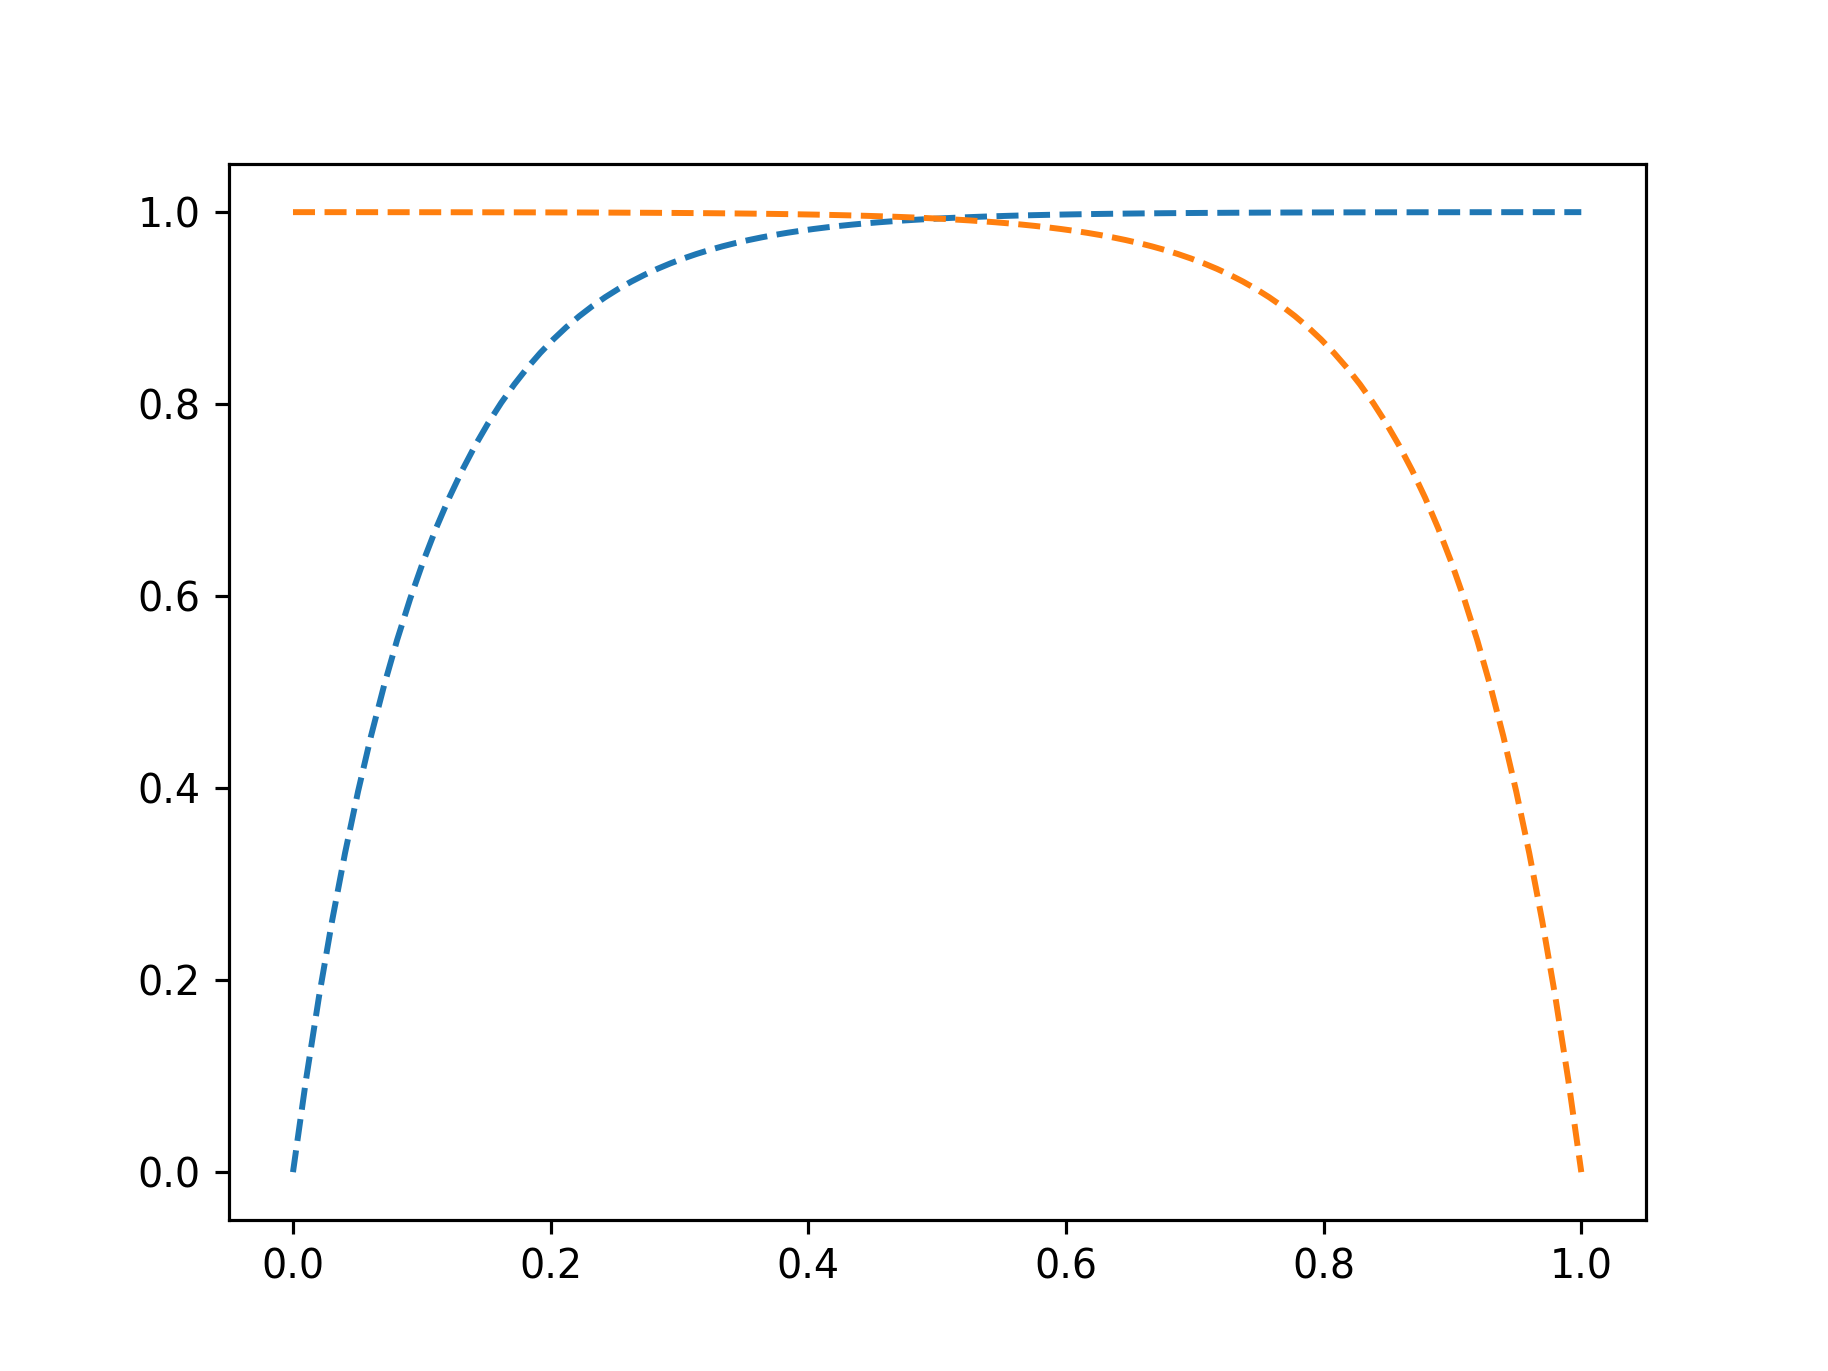

In [26]:
# IDEA: Model Neuronal saturation, because truncation feels unphysical
x = np.linspace(0, 1, 100)
tau = 10
y1 = 1 - np.exp(-tau * x)

y2 = 1 - np.exp(tau*(x-1))

plt.plot(x,y1, '--')
plt.plot(x,y2, '--')
plt.show()

In [ ]:
plt.figure()
seqGen(NTot, NCoding, WLen_Lst, WFreq_Lst, TTot)